In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [47]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
sys.path.append('../code')
import tools, tfpmconfig, tfpmfuncs, tfpm
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100]

In [209]:
meshes = {}
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['s'] = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/s/')

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    meshes[seed] = [mesh, hmesh]

config = tfpmconfig.Config(bs=bs, nc=nc)


In [204]:
base = meshes[100][1]['pcic']
base = (base - base.mean())/base.mean()

In [ ]:
configig

In [232]:
kk[-1].shape

(1, 1, 65)

In [235]:
config['kvec'][-1].shape

(1, 1, 128)

In [205]:
basesm = tools.gauss(base, kk, 4)

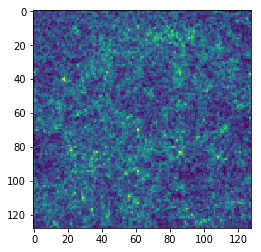

In [206]:
plt.imshow(base.sum(axis=0))

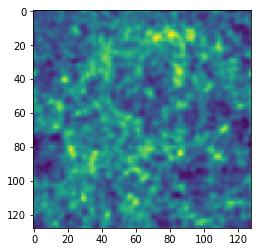

In [207]:
plt.imshow(basesm.sum(axis=0))

In [223]:
pfin = tools.power(meshes[100][0]['cic'], boxsize=bs)[1]
ph = tools.power(1+base, boxsize=bs)[1]
bias = ((ph[1:5]/pfin[1:5])**0.5).mean()
print(bias)


tfmesh = tf.constant(basesm.astype(np.float32))
# tfmesh = tf.constant(meshes[100][0]['cic'].astype(np.float32))
tfmeshk = tfpmfuncs.r2c3d(tfmesh, norm=nc**3)

tfDX = tfpm.lpt1(tfmeshk, hposd, config)
tfDX = tf.multiply(tfDX, -1/bias)
tfpos = tf.add(hposd, tfDX)
tfmesh2 = tf.zeros_like(tfmesh)
tfmesh2 = tfpm.cic_paint(tfmesh2, tfpos, boxsize=bs)

tfDX = tfpm.lpt1(tfmeshk, config['grid'], config)
tfDX = tf.multiply(tfDX, -1/bias)
tfpos = tf.add(config['grid'], tfDX)
tfrandom = tf.zeros_like(tfmesh)
tfrandom = tfpm.cic_paint(tfrandom, tfpos, boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    hmesh2, random, dx = sess.run([tfmesh2, tfrandom, tfDX])

1.166066437769569


In [236]:
g = tf.get_default_graph()

In [239]:
g.get_collection()

TypeError: get_collection_ref() missing 1 required positional argument: 'name'

In [224]:
hmesh2d = (hmesh2 - hmesh2.mean())/hmesh2.mean()
randomd = (random - random.mean())/random.mean()
recon = hmesh2d - randomd

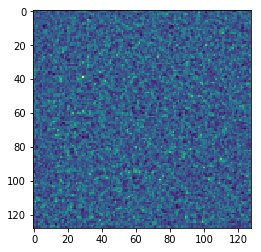

In [225]:
plt.imshow(hmesh2d.sum(axis=0))

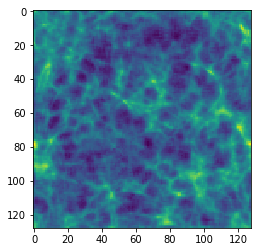

In [226]:
plt.imshow(randomd.sum(axis=0))

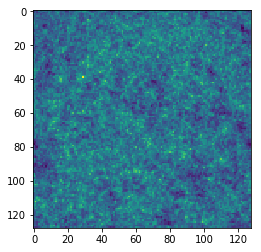

In [227]:
plt.imshow((recon).sum(axis=0))

In [228]:
pin = tools.power(1+meshes[100][0]['s'], boxsize=bs)
k, pin = pin[0], pin[1]

prec = tools.power(recon, boxsize=bs)[1]
precx = tools.power(1+meshes[100][0]['s'], recon, boxsize=bs)[1]

# ph = tools.power(hmesh, boxsize=bs)[1]
# phx = tools.power(meshes[100][0]['cic'], hmesh, boxsize=bs)[1]
ph = tools.power(base, boxsize=bs)[1]
phx = tools.power(1+meshes[100][0]['s'], base, boxsize=bs)[1]

ph2 = tools.power(hmesh2, boxsize=bs)[1]
ph2x = tools.power(1+meshes[100][0]['s'], hmesh2, boxsize=bs)[1]

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


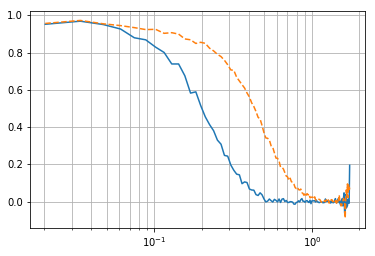

In [229]:
plt.plot(k, phx/(pin*ph)**0.5)
plt.plot(k, precx/(pin*prec)**0.5, '--')
plt.xscale('log')
plt.grid(which='both')